# Iowa Housing Pricing: Modeling & Analysis

### Contents
 - [0. Pickling Work Space](#Pickling-Work-Space)
 - [I. Processing & Scaling](#Processing-&-Scaling)
 - [II. Initial Regressive Models](#Train-Initial-Regressive-Models)
     - [a. PCA Pipelined](#Regressions-with-PCA-Pipelined)
     - [b. Using GridSearchCV](#Regressions-with-GridSearchCV)
 - [III. Second Iteration: Outliers & Cook's Distance](#Second-Iteration:-Dealing-with-Outliers)
     - [a. Leverage Plot Visualization](#Leverage-Plot)
     - [b. Initial Cooked Regressions](#Model-Cooked-Regressions)
     - [c. Cooked PCA Pipelined](#Cooked-PCA-Pipeline)
     - [d. Cooked GridSearchCV](#Cooked-GridSearchCV)
 - [IV. Feature / Permutation Importance](#Ascertain-Feature-Importance)
     - [a. Un-Cooked Feature Importance](#Un-Cooked-Feature-Importance)
     - [b. Cooked Feature Importance](#Cooked-Feature-Importance)
     - [c. Permutation Importance](#Opting-for-Permutation-Importance)

In [1]:
# Import packages etc.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle

# Import data
x_train = pd.read_csv('ITrain_DSet.csv').drop(['Unnamed: 0'], axis=1)
y_train = pd.read_csv('ITrain_Test.csv').drop(['Unnamed: 0'], axis=1)
x_test = pd.read_csv('ITTest_DSet.csv').drop(['Unnamed: 0'], axis=1)
y_test = pd.read_csv('ITTest_Test.csv').drop(['Unnamed: 0'], axis=1)
sample_result = pd.read_csv('sample_submission.csv')
testset = pd.read_csv('test.csv')


#### Pickling Work Space
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [2]:
################################
### Cheek's Pickling EXPORTS ###
################################

### First Run
# pickle.dump(gs_ridge, open(f'./gsridge.pkl', 'wb'))
# pickle.dump(gs_svr, open(f'./gssvr.pkl', 'wb'))
# pickle.dump(gs_randomForest, open(f'./gsrforest.pkl', 'wb'))
# pickle.dump(gs_gradientBoost, open(f'./gsgradient.pkl', 'wb'))
# pickle.dump(gs_xgForest, open(f'./gsxgforest.pkl', 'wb'))
# pickle.dump(gs_xgBooster, open(f'./gsxgbooster.pkl', 'wb'))

### Cooked Run
# pickle.dump(cooked_ridge, open(f'./cooked_ridge.pkl', 'wb'))
# pickle.dump(cooked_svr, open(f'./cooked_svr.pkl', 'wb'))
# pickle.dump(cooked_randomForest, open(f'./cooked_rf.pkl', 'wb'))
# pickle.dump(cooked_gradientBoost, open(f'./cooked_gb.pkl', 'wb'))
# pickle.dump(cooked_xgForest, open(f'./cooked_xgrf.pkl', 'wb'))
# pickle.dump(cooked_xgBooster, open(f'./cooked_xgb.pkl', 'wb'))

In [3]:
###############################
### IMPORT Choicest Pickles ###
###############################

gs_ridge = pickle.load(open('./gsridge.pkl', 'rb'))
gs_svr = pickle.load(open('./gssvr.pkl', 'rb'))
gs_randomForest = pickle.load(open('./gsrforest.pkl', 'rb'))
gs_gradientBoost = pickle.load(open('./gsgradient.pkl', 'rb'))
gs_xgForest = pickle.load(open('./gsxgforest.pkl', 'rb'))
gs_xgBooster = pickle.load(open('./gsxgbooster.pkl', 'rb'))
cooked_ridge = pickle.load(open('./cooked_ridge.pkl', 'rb'))
cooked_svr = pickle.load(open('./cooked_svr.pkl', 'rb'))
cooked_randomForest = pickle.load(open('./cooked_rf.pkl', 'rb'))
cooked_gradientBoost = pickle.load(open('./cooked_gb.pkl', 'rb'))
cooked_xgForest = pickle.load(open('./cooked_xgrf.pkl', 'rb'))
cooked_xgBoost = pickle.load(open('./cooked_xgb.pkl', 'rb'))

# Processing & Scaling
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

As we have already imported fully cleaned and prepared data, we merely need to begin the processing. To start, we will scale the data using SKLearn's **StandardScaler**.

In [4]:
from sklearn.preprocessing import StandardScaler

# Scale data & save scaler model
scale = StandardScaler()
x_train = pd.DataFrame(scale.fit_transform(x_train),   # Fit & Transform Train
                      columns=x_train.columns.to_list())
x_test = pd.DataFrame(scale.transform(x_test),         # Transform Test Per Train
                     columns=x_test.columns.to_list())
pickle.dump(scale, open('./scale.pkl', 'wb'))          # Save Scale Pickle

# Train Initial Regressive Models
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

In order to attempt a broad analysis of our data, we will include classical, sklearn regression techniques, ranging from **Ridge & Lasso regressions** to svm's **Support Vector Regression**, and further to ensemble's **Random Forest Regressor** as well as **Gradient Boosting Regressor**.

We will complement our analysis with the popular *XGBoost* **Random Forest Regressor** and **Gradient Boosting Regressor** to compare their results with those of the native sklearn package.

In [5]:
from sklearn import linear_model, svm, ensemble
import xgboost as xgb

#####################
### Define Models ###
#####################

ridge = linear_model.Ridge()
svr = svm.SVR()
randomForest = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

models = [ridge, svr, randomForest, gradientBoost, xgForest, xgBooster]

# Make results df
resul = pd.DataFrame(columns = ['Model', 'Ridge', 'SVR', 'RForest', 'GBoost', 'XGRForest', 'XGBoost'])
resul.set_index("Model", inplace = True)
resul.loc['StandardTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['StandardTest'] = [0, 0, 0, 0, 0, 0]
resul.loc['PCATrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['PCATest'] = [0, 0, 0, 0, 0, 0]
resul.loc['GridTrain'] = [0, 0, 0, 0, 0, 0]
resul.loc['GridTest'] = [0, 0, 0, 0, 0, 0]

##########################################
### Build & Test Models w/o GridSearch ###
##########################################

col = 0
for model in models:
    model.fit(x_train, y_train['SalePrice'])
    resul.iloc[0, col] = model.score(x_train, y_train['SalePrice'])
    resul.iloc[1, col] = model.score(x_test, y_test['SalePrice'])
    col += 1

resul.head(6)

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0,0,0,0,0,0
PCATest,0,0,0,0,0,0
GridTrain,0,0,0,0,0,0
GridTest,0,0,0,0,0,0


## Regressions with PCA Pipelined
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

#
pca_p = PCA(n_components=0.99, random_state=430, svd_solver='full')
ridgep = linear_model.Ridge()
svrp = svm.SVR()
rforestp = ensemble.RandomForestRegressor(n_jobs=-2, random_state=430)
gboostp = ensemble.GradientBoostingRegressor(random_state=430)
xgrfp = xgb.XGBRFRegressor(n_jobs=-2, random_state=430)
xgbp = xgb.XGBRegressor(n_jobs=-2, random_state=430)

#
ridgep = Pipeline(steps=[('pca', pca_p), 
                         ('ridge', linear_model.Ridge())])
svrp = Pipeline(steps=[('pca', pca_p),
                      ('model', svm.SVR())])
rforestp = Pipeline(steps=[('pca', pca_p),
                          ('model', rforestp)])
gboostp = Pipeline(steps=[('pca', pca_p),
                         ('model', gboostp)])
xgrfp = Pipeline(steps=[('pca', pca_p),
                       ('model', xgrfp)])
xgbp = Pipeline(steps=[('pca', pca_p),
                      ('model', xgbp)])

models2 = [ridgep, svrp, rforestp, gboostp, xgrfp, xgbp]

#
col = 0
for model in models2:
    model.fit(x_train, y_train['SalePrice'])
    resul.iloc[2, col] = model.score(x_train, y_train['SalePrice'])
    resul.iloc[3, col] = model.score(x_test, y_test['SalePrice'])
    print(model.get_params())
    col += 1
    
resul.head(6)

# resul.head(6)

{'memory': None, 'steps': [('pca', PCA(n_components=0.99, random_state=430, svd_solver='full')), ('ridge', Ridge())], 'verbose': False, 'pca': PCA(n_components=0.99, random_state=430, svd_solver='full'), 'ridge': Ridge(), 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': 0.99, 'pca__random_state': 430, 'pca__svd_solver': 'full', 'pca__tol': 0.0, 'pca__whiten': False, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001}
{'memory': None, 'steps': [('pca', PCA(n_components=0.99, random_state=430, svd_solver='full')), ('model', SVR())], 'verbose': False, 'pca': PCA(n_components=0.99, random_state=430, svd_solver='full'), 'model': SVR(), 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': 0.99, 'pca__random_state': 430, 'pca__svd_solver': 'full', 'pca__tol': 0.0, 'pca__whiten': False, 'model__C': 1.0, 'mod

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0,0,0,0,0,0
GridTest,0,0,0,0,0,0


## Regressions with GridSearchCV
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

From here we can see that we may need to adjust some parameters to yield better results. In order to achieve our goals, we will implement the classic **GridSearchCV** from SKLearn's model_selection.

In order to save on processing time, we will split each process into its own cell, duplicating syntax for readability and ease of tweaking.

In [7]:
###################
### Ridge Model ###
###################

# import new toys
from sklearn import model_selection

# reset items
ridge2 = linear_model.Ridge()
pca = PCA(random_state=430)

# pipe & search
ridge_grid = {'pca__n_components': [0.99],
             'model__alpha': [0.01, 0.1, 1, 10, 100, 1000]}
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', ridge2)])
gs_ridge = model_selection.GridSearchCV(pipeline, ridge_grid, n_jobs=-2, cv=3)
gs_ridge.fit(x_train, y_train['SalePrice'])
print('Ridge Regressor Params: ' + str(gs_ridge.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[4, 0] = gs_ridge.score(x_train, y_train['SalePrice'])
resul.iloc[5, 0] = gs_ridge.score(x_test, y_test['SalePrice'])
resul.head(6)

Ridge Regressor Params: {'model__alpha': 1000, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0.872866,0,0,0,0,0
GridTest,0.854558,0,0,0,0,0


In [9]:
############################
### Support Vector Model ###
############################

# reset items
svr2 = svm.SVR()
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', svr2)])
svr_grid = {'pca__n_components': [0.99],
           'model__kernel': ['linear', 'poly', 'rbf'],
           'model__C': [0.01, 0.1, 1, 10, 100, 1000],
           'model__gamma': ['scale']}
gs_svr = model_selection.GridSearchCV(pipeline, svr_grid, n_jobs=-2, cv=3)
gs_svr.fit(x_train, y_train['SalePrice'])
print('Ridge Regressor Params: ' + str(gs_svr.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[4, 1] = gs_svr.score(x_train, y_train['SalePrice'])
resul.iloc[5, 1] = gs_svr.score(x_test, y_test['SalePrice'])
resul.head(6)

Ridge Regressor Params: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'linear', 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0.872866,0.844854,0,0,0,0
GridTest,0.854558,0.859421,0,0,0,0


In [10]:
###############################
### Random Forest Regressor ###
###############################

randomForest2 = ensemble.RandomForestRegressor(n_jobs=-2, random_state=430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', randomForest2)])
rf_grid = {'pca__n_components': [0.99],
          'model__n_estimators': [500, 750, 1000],
          'model__max_features': ['auto', 'sqrt', 'log2'],
          'model__max_depth': [10, 11, 12, None],
          'model__min_samples_split': [2, 5, 10],
          'model__min_samples_leaf': [1, 2, 4]}
gs_randomForest = model_selection.GridSearchCV(pipeline, rf_grid, n_jobs=-2, cv=3)
gs_randomForest.fit(x_train, y_train['SalePrice'])
print('RandomForest Params: ' + str(gs_randomForest.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[4, 2] = gs_randomForest.score(x_train, y_train['SalePrice'])
resul.iloc[5, 2] = gs_randomForest.score(x_test, y_test['SalePrice'])
resul.head(6)

RandomForest Params: {'model__max_depth': 11, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 750, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0.872866,0.844854,0.972381,0,0,0
GridTest,0.854558,0.859421,0.861758,0,0,0


In [11]:
################################
### Gradient Boost Regressor ###
################################

gradientBoost2 = ensemble.GradientBoostingRegressor(random_state=430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', gradientBoost2)])
gb_grid = {'pca__n_components': [0.99],
          'model__min_samples_split': [2, 5, 10],
          'model__min_samples_leaf': [1, 2, 4],
          'model__n_estimators': [500, 750, 1000],
          'model__max_depth': [4, 5, 6, None]}
gs_gradientBoost = model_selection.GridSearchCV(pipeline, gb_grid, n_jobs=-2, cv=3)
gs_gradientBoost.fit(x_train, y_train['SalePrice'])
print('GradientBoost Params: ' + str(gs_gradientBoost.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[4, 3] = gs_gradientBoost.score(x_train, y_train['SalePrice'])
resul.iloc[5, 3] = gs_gradientBoost.score(x_test, y_test['SalePrice'])
resul.head(6)

GradientBoost Params: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 750, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0.872866,0.844854,0.972381,1.0,0,0
GridTest,0.854558,0.859421,0.861758,0.875904,0,0


In [12]:
#################################
### XGRandom Forest Regressor ###
#################################

xgForest2 = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgForest2)])
xgf_grid = {'model__n_estimators': [100, 250, 500, 750],
           'model__max_depth': [6, 10, 14, 18, 22, 26],
           'model__gamma': [0, 2, 4]}
gs_xgForest = model_selection.GridSearchCV(pipeline, xgf_grid, n_jobs=-2, cv=3)
gs_xgForest.fit(x_train, y_train['SalePrice'])
print('XGRandomForest Params: ' + str(gs_xgForest.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[4, 4] = gs_xgForest.score(x_train, y_train['SalePrice'])
resul.iloc[5, 4] = gs_xgForest.score(x_test, y_test['SalePrice'])
resul.head(6)

XGRandomForest Params: {'model__gamma': 0, 'model__max_depth': 14, 'model__n_estimators': 500}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0.872866,0.844854,0.972381,1.0,0.986777,0
GridTest,0.854558,0.859421,0.861758,0.875904,0.861007,0


In [13]:
#########################
### XGBoost Regressor ###
#########################

xgBooster2 = xgb.XGBRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgBooster2)])
xgb_grid = {'pca__n_components': range(50, x_train.shape[1]),
            'model__n_estimators': [100, 250, 500],
            'model__max_depth': [2, 3, 4, 5],
            'model__gamma': [0, 1, 2, 3]}
gs_xgBooster = model_selection.GridSearchCV(pipeline, xgb_grid, n_jobs=-2, cv=3)
gs_xgBooster.fit(x_train, y_train['SalePrice'])
print('XGBooster Params: ' + str(gs_xgBooster.best_params_))

# Tabulate Train Score & Test Score
resul.iloc[4, 5] = gs_xgBooster.score(x_train, y_train['SalePrice'])
resul.iloc[5, 5] = gs_xgBooster.score(x_test, y_test['SalePrice'])
resul.head(6)

XGBooster Params: {'model__gamma': 0, 'model__max_depth': 2, 'model__n_estimators': 100, 'pca__n_components': 100}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.930239,-0.046976,0.972468,0.970537,0.946905,0.999669
StandardTest,0.729134,-0.075253,0.879944,0.920406,0.870269,0.871071
PCATrain,0.906358,-0.046969,0.972615,0.972227,0.944913,1.0
PCATest,0.842698,-0.075242,0.863165,0.86956,0.846511,0.846602
GridTrain,0.872866,0.844854,0.972381,1.0,0.986777,0.959371
GridTest,0.854558,0.859421,0.861758,0.875904,0.861007,0.856726


# Second Iteration: Dealing with Outliers

[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [14]:
# Get OLS Info
import statsmodels.api as sms

x_addconst = sms.add_constant(x_train)
OLS = sms.OLS(y_train, x_addconst)
result_ols = OLS.fit()

print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     56.35
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:18:22   Log-Likelihood:                -13260.
No. Observations:                1168   AIC:                         2.698e+04
Df Residuals:                     939   BIC:                         2.814e+04
Df Model:                         228                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.797e+

In [15]:
# Focus in on Influences
influence = result_ols.get_influence()
pd.Series(influence.hat_matrix_diag).describe()

count    1168.000000
mean        0.196061
std         0.169858
min        -0.044114
25%         0.096158
50%         0.141082
75%         0.229474
max         1.000000
dtype: float64

In [16]:
# Get Influence Summary Frame
infl_summaryfr = influence.summary_frame()
infl_summaryfr.head(3)

/home/theodore/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/home/theodore/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: divide by zero encountered in true_divide
  return self.resid / sigma / np.sqrt(1 - hii)
/home/theodore/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:713: RuntimeWarning: divide by zero encountered in true_divide
  cooks_d2 *= hii / (1 - hii)
/home/theodore/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:733: RuntimeWarning: divide by zero encountered in true_divide
  dffits_ = self.resid_studentized_internal * np.sqrt(hii / (1 - hii))
/home/theodore/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:733: RuntimeWarning: invalid value encountered in sqrt
  dffits_ = self.resid_studentized_intern

,dfb_const,dfb_LotFrontage,dfb_LotArea,dfb_OverallQual,dfb_OverallCond,dfb_YrsSinceBlt,dfb_YrsSinceRemod,dfb_MasVnrArea,dfb_BsmtUnfSF,dfb_TotalBsmtSF,...,dfb_FireplaceQu,dfb_GarageFinish,dfb_GarageQual,dfb_GarageCond,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.321284,0.189120,0.006737,-0.004514,0.012875,0.017413,0.057582,-0.000602,0.018442,-0.033877,...,0.022928,0.035159,0.020313,-0.017721,-1.544193e-05,0.311802,-0.044114,NaN,0.312015,NaN
1,0.081099,-0.058864,-0.001272,0.014901,-0.009589,-0.001140,0.015503,-0.007617,0.005185,-0.001236,...,0.002863,0.015044,0.006680,0.000377,-1.144510e-07,-0.033632,-0.027660,NaN,-0.033698,NaN
2,-0.025873,-0.047203,0.005213,-0.020419,-0.007519,0.009157,0.011618,0.009511,0.009783,-0.005822,...,0.002588,0.009336,0.008037,0.000656,2.322902e-08,-0.004920,0.203329,-0.002486,-0.004931,-0.002491


## Leverage Plot
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


/home/theodore/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Studentized Residuals')

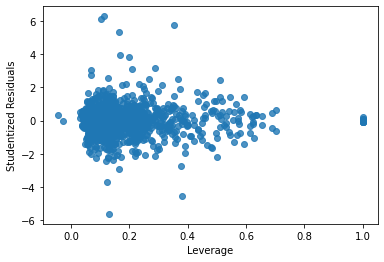

In [17]:
# Plot Leverage of Data
lever = influence.hat_matrix_diag
sns.regplot(lever, result_ols.resid_pearson, fit_reg=False)
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')

In [18]:
# Combine Summary Frame & Prices
infl_sum = pd.concat([y_train['SalePrice'], infl_summaryfr], axis=1)
infl_sum = infl_sum.rename(columns={'hat_diag': 'leverage'})
infl_sum.head()

,SalePrice,dfb_const,dfb_LotFrontage,dfb_LotArea,dfb_OverallQual,dfb_OverallCond,dfb_YrsSinceBlt,dfb_YrsSinceRemod,dfb_MasVnrArea,dfb_BsmtUnfSF,...,dfb_FireplaceQu,dfb_GarageFinish,dfb_GarageQual,dfb_GarageCond,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,93000,-0.321284,0.189120,0.006737,-0.004514,0.012875,0.017413,0.057582,-0.000602,0.018442,...,0.022928,0.035159,0.020313,-0.017721,-1.544193e-05,0.311802,-0.044114,NaN,0.312015,NaN
1,172500,0.081099,-0.058864,-0.001272,0.014901,-0.009589,-0.001140,0.015503,-0.007617,0.005185,...,0.002863,0.015044,0.006680,0.000377,-1.144510e-07,-0.033632,-0.027660,NaN,-0.033698,NaN
2,135000,-0.025873,-0.047203,0.005213,-0.020419,-0.007519,0.009157,0.011618,0.009511,0.009783,...,0.002588,0.009336,0.008037,0.000656,2.322902e-08,-0.004920,0.203329,-0.002486,-0.004931,-0.002491
3,100000,0.005254,-0.067018,-0.011026,-0.000665,-0.008998,-0.022258,-0.003271,0.007359,-0.009381,...,-0.002241,-0.003564,0.000262,0.009551,5.189086e-05,-0.248450,0.182747,-0.117486,-0.248962,-0.117728
4,261500,0.127692,-0.024602,0.003121,0.020052,-0.001161,-0.009235,0.020470,0.002643,0.006410,...,0.010190,0.002625,0.008759,0.003490,1.424852e-07,-0.021926,0.073078,-0.006156,-0.021967,-0.006168


In [19]:
# Isolate Outliers via Cook's Distance from Influence Mtx
cutoff = 4/x_train.shape[0]
cookdf = pd.DataFrame((infl_sum.SalePrice[abs(infl_sum.cooks_d) > cutoff]))
cook_outliers = [*cookdf.index]
print(cook_outliers)

[35, 54, 56, 57, 62, 123, 129, 162, 163, 169, 193, 202, 226, 240, 264, 270, 272, 275, 280, 288, 289, 296, 303, 334, 339, 367, 371, 386, 410, 414, 434, 444, 451, 455, 462, 464, 473, 474, 492, 508, 521, 523, 529, 532, 541, 542, 550, 551, 573, 574, 599, 627, 668, 673, 682, 684, 691, 699, 700, 705, 711, 713, 720, 721, 726, 739, 749, 751, 765, 768, 789, 834, 842, 870, 883, 915, 921, 926, 938, 954, 958, 974, 977, 997, 1013, 1016, 1024, 1026, 1027, 1055, 1057, 1063, 1066, 1071, 1077, 1080, 1084, 1089, 1094, 1101, 1136, 1146, 1154, 1165]


In [20]:
############################
### Generate Cooked Data ###
############################

# Cook Data
cooked_xtrain = x_train.copy()
cooked_ytrain = y_train.copy()

cooked_xtrain.drop(cook_outliers, axis=0, inplace=True)
cooked_ytrain.drop(cook_outliers, axis=0, inplace=True)

# Model Cooked Regressions
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [22]:
#######################
### Redefine Models ###
#######################

ridge2 = linear_model.Ridge()
svr2 = svm.SVR()
randomForest2 = ensemble.RandomForestRegressor(n_jobs = -2,random_state = 430)
gradientBoost2 = ensemble.GradientBoostingRegressor(random_state = 430)
xgForest2 = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
xgBooster2 = xgb.XGBRegressor(n_jobs = -2, random_state = 430)

models = [ridge2, svr2, randomForest2, gradientBoost2, xgForest2, xgBooster2]

# Make results df
cooked_resul = pd.DataFrame(columns = ['Model', 'Ridge', 'SVR', 'RForest', 'GBoost', 'XGRForest', 'XGBoost'])
cooked_resul.set_index("Model", inplace = True)
cooked_resul.loc['StandardTrain'] = [0, 0, 0, 0, 0, 0]
cooked_resul.loc['StandardTest'] = [0, 0, 0, 0, 0, 0]
cooked_resul.loc['PCATrain'] = [0, 0, 0, 0, 0, 0]
cooked_resul.loc['PCATest'] = [0, 0, 0, 0, 0, 0]
cooked_resul.loc['GridTrain'] = [0, 0, 0, 0, 0, 0]
cooked_resul.loc['GridTest'] = [0, 0, 0, 0, 0, 0]

##########################################
### Build & Test Models w/o GridSearch ###
##########################################

col = 0
for model in models:
    model.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
    cooked_resul.iloc[0, col] = model.score(cooked_xtrain, cooked_ytrain['SalePrice'])
    cooked_resul.iloc[1, col] = model.score(x_test, y_test['SalePrice'])
    col += 1

cooked_resul.head(6)

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0,0,0,0,0,0
PCATest,0,0,0,0,0,0
GridTrain,0,0,0,0,0,0
GridTest,0,0,0,0,0,0


## Cooked PCA Pipeline
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Reset Models
pca_p2 = PCA(n_components=0.99, random_state=430, svd_solver='full')
ridgep2 = linear_model.Ridge()
svrp2 = svm.SVR()
rforestp2 = ensemble.RandomForestRegressor(n_jobs=-2, random_state=430)
gboostp2 = ensemble.GradientBoostingRegressor(random_state=430)
xgrfp2 = xgb.XGBRFRegressor(n_jobs=-2, random_state=430)
xgbp2 = xgb.XGBRegressor(n_jobs=-2, random_state=430)

# Generate Pipelines
ridgep2 = Pipeline(steps=[('pca', pca_p2), 
                         ('ridge', ridgep2)])
svrp2 = Pipeline(steps=[('pca', pca_p2),
                      ('model', svrp2)])
rforestp2 = Pipeline(steps=[('pca', pca_p2),
                          ('model', rforestp2)])
gboostp2 = Pipeline(steps=[('pca', pca_p2),
                         ('model', gboostp2)])
xgrfp2 = Pipeline(steps=[('pca', pca_p2),
                       ('model', xgrfp2)])
xgbp2 = Pipeline(steps=[('pca', pca_p2),
                      ('model', xgbp2)])

models = [ridgep2, svrp2, rforestp2, gboostp2, xgrfp2, xgbp2]

col = 0
for model in models:
    model.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
    cooked_resul.iloc[2, col] = model.score(cooked_xtrain, cooked_ytrain['SalePrice'])
    cooked_resul.iloc[3, col] = model.score(x_test, y_test['SalePrice'])
    col += 1
    
cooked_resul.head(6)

,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973201,0.976793,0.949182,1.0
PCATest,0.876975,-0.08707,0.826123,0.852878,0.814083,0.842671
GridTrain,0,0,0,0,0,0
GridTest,0,0,0,0,0,0


## Cooked GridSearchCV
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [53]:
###################
### Ridge Model ###
###################

# import new toys
from sklearn import model_selection

# reset items
ridge2 = linear_model.Ridge()
pca = PCA(random_state=430)

# pipe & search
ridge_grid = {'pca__n_components': [0.99],
             'model__alpha': np.arange(270, 280, 0.1)}
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', ridge2)])
cooked_ridge = model_selection.GridSearchCV(pipeline, ridge_grid, n_jobs=-2, cv=3)
cooked_ridge.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
print('Ridge Regressor Params: ' + str(cooked_ridge.best_params_))

# Tabulate Train Score & Test Score
cooked_resul.iloc[4, 0] = cooked_ridge.score(cooked_xtrain, cooked_ytrain['SalePrice'])
cooked_resul.iloc[5, 0] = cooked_ridge.score(x_test, y_test['SalePrice'])
cooked_resul.head(6)

Ridge Regressor Params: {'model__alpha': 272.90000000000066, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973405,0.97577,0.949749,1.0
PCATest,0.876975,-0.08707,0.829311,0.859201,0.815112,0.815631
GridTrain,0.930207,0,0,0,0,0
GridTest,0.868489,0,0,0,0,0


In [54]:
############################
### Support Vector Model ###
############################

# reset items
svr2 = svm.SVR(kernel='linear')
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', svr2)])
svr_grid = {'pca__n_components': [0.99],
           'model__C': np.arange(128, 140, 0.1),
           'model__epsilon': np.arange(998, 1000, 0.1)}
cooked_svr = model_selection.GridSearchCV(pipeline, svr_grid, n_jobs=-2, cv=3)
cooked_svr.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
print('Ridge Regressor Params: ' + str(cooked_svr.best_params_))

# Tabulate Train Score & Test Score
cooked_resul.iloc[4, 1] = cooked_svr.score(cooked_xtrain, cooked_ytrain['SalePrice'])
cooked_resul.iloc[5, 1] = cooked_svr.score(x_test, y_test['SalePrice'])
cooked_resul.head(6)

Ridge Regressor Params: {'model__C': 129.29999999999993, 'model__epsilon': 999.9000000000004, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973405,0.97577,0.949749,1.0
PCATest,0.876975,-0.08707,0.829311,0.859201,0.815112,0.815631
GridTrain,0.930207,0.894968,0,0,0,0
GridTest,0.868489,0.862268,0,0,0,0


In [55]:
###############################
### Random Forest Regressor ###
###############################

randomForest2 = ensemble.RandomForestRegressor(n_jobs=-2, random_state=430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', randomForest2)])
rf_grid = {'pca__n_components': [0.99],
          'model__n_estimators': [500, 750, 1000],
          'model__max_features': ['auto', 'sqrt', 'log2'],
          'model__max_depth': [10, 11, 12, None],
          'model__min_samples_split': [2, 5, 10],
          'model__min_samples_leaf': [1, 2, 4]}
cooked_randomForest = model_selection.GridSearchCV(pipeline, rf_grid, n_jobs=-2, cv=3)
cooked_randomForest.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
print('RandomForest Params: ' + str(cooked_randomForest.best_params_))

# Tabulate Train Score & Test Score
cooked_resul.iloc[4, 2] = cooked_randomForest.score(cooked_xtrain, cooked_ytrain['SalePrice'])
cooked_resul.iloc[5, 2] = cooked_randomForest.score(x_test, y_test['SalePrice'])
cooked_resul.head(6)

RandomForest Params: {'model__max_depth': 10, 'model__max_features': 'auto', 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 500, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973405,0.97577,0.949749,1.0
PCATest,0.876975,-0.08707,0.829311,0.859201,0.815112,0.815631
GridTrain,0.930207,0.894968,0.962963,0,0,0
GridTest,0.868489,0.862268,0.837503,0,0,0


In [56]:
################################
### Gradient Boost Regressor ###
################################

gradientBoost2 = ensemble.GradientBoostingRegressor(random_state=430)
pca = PCA(random_state=430)

# pipe & search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', gradientBoost2)])
gb_grid = {'pca__n_components': [0.99],
          'model__min_samples_split': [2, 5, 10],
          'model__min_samples_leaf': [1, 2, 4],
          'model__n_estimators': [500, 750, 1000],
          'model__max_depth': [4, 5, 6, None]}
cooked_gradientBoost = model_selection.GridSearchCV(pipeline, gb_grid, n_jobs=-2, cv=3)
cooked_gradientBoost.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
print('GradientBoost Params: ' + str(cooked_gradientBoost.best_params_))

# Tabulate Train Score & Test Score
cooked_resul.iloc[4, 3] = cooked_gradientBoost.score(cooked_xtrain, cooked_ytrain['SalePrice'])
cooked_resul.iloc[5, 3] = cooked_gradientBoost.score(x_test, y_test['SalePrice'])
cooked_resul.head(6)

GradientBoost Params: {'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 1000, 'pca__n_components': 0.99}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973405,0.97577,0.949749,1.0
PCATest,0.876975,-0.08707,0.829311,0.859201,0.815112,0.815631
GridTrain,0.930207,0.894968,0.962963,1.0,0,0
GridTest,0.868489,0.862268,0.837503,0.860892,0,0


In [57]:
#################################
### XGRandom Forest Regressor ###
#################################

xgForest2 = xgb.XGBRFRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgForest2)])
xgf_grid = {'model__n_estimators': [100, 250, 500, 750],
           'model__max_depth': [6, 10, 14, 18, 22, 26],
           'model__gamma': [0, 2, 4]}
cooked_xgForest = model_selection.GridSearchCV(pipeline, xgf_grid, n_jobs=-2, cv=3)
cooked_xgForest.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
print('XGRandomForest Params: ' + str(cooked_xgForest.best_params_))

# Tabulate Train Score & Test Score
cooked_resul.iloc[4, 4] = cooked_xgForest.score(cooked_xtrain, cooked_ytrain['SalePrice'])
cooked_resul.iloc[5, 4] = cooked_xgForest.score(x_test, y_test['SalePrice'])
cooked_resul.head(6)

XGRandomForest Params: {'model__gamma': 0, 'model__max_depth': 18, 'model__n_estimators': 500}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973405,0.97577,0.949749,1.0
PCATest,0.876975,-0.08707,0.829311,0.859201,0.815112,0.815631
GridTrain,0.930207,0.894968,0.962963,1.0,0.985607,0
GridTest,0.868489,0.862268,0.837503,0.860892,0.835072,0


In [58]:
#########################
### XGBoost Regressor ###
#########################

xgBooster2 = xgb.XGBRegressor(n_jobs = -2, random_state = 430)
pca = PCA(random_state=430)

# Pipe & Search
pipeline = Pipeline(steps=[('pca', pca),
                          ('model', xgBooster2)])
xgb_grid = {'pca__n_components': range(50, x_train.shape[1]),
            'model__n_estimators': [100, 250, 500],
            'model__max_depth': [2, 3, 4, 5],
            'model__gamma': [0, 1, 2, 3]}
cooked_xgBoost = model_selection.GridSearchCV(pipeline, xgb_grid, n_jobs=-2, cv=3)
cooked_xgBoost.fit(cooked_xtrain, cooked_ytrain['SalePrice'])
print('XGBooster Params: ' + str(cooked_xgBoost.best_params_))

# Tabulate Train Score & Test Score
cooked_resul.iloc[4, 5] = cooked_xgBoost.score(cooked_xtrain, cooked_ytrain['SalePrice'])
cooked_resul.iloc[5, 5] = cooked_xgBoost.score(x_test, y_test['SalePrice'])
cooked_resul.head(6)

XGBooster Params: {'model__gamma': 0, 'model__max_depth': 2, 'model__n_estimators': 500, 'pca__n_components': 167}


,Ridge,SVR,RForest,GBoost,XGRForest,XGBoost
Model,,,,,,
StandardTrain,0.958415,-0.046018,0.976465,0.975735,0.950145,0.999816
StandardTest,0.82881,-0.087092,0.864557,0.894376,0.849166,0.873021
PCATrain,0.93877,-0.046012,0.973405,0.97577,0.949749,1.0
PCATest,0.876975,-0.08707,0.829311,0.859201,0.815112,0.815631
GridTrain,0.930207,0.894968,0.962963,1.0,0.985607,0.998982
GridTest,0.868489,0.862268,0.837503,0.860892,0.835072,0.865133


# Ascertain Feature Importance
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)

Best practice follows that we obtain the feature importance of best-performing models. We can see these below, easily obtained for randomForest and gradientBoost models. However, according to research into the feature importance methodology, ascertaining *permutation importance* instead may be more accurate, which we shall perform below.

## Un-Cooked Feature Importance

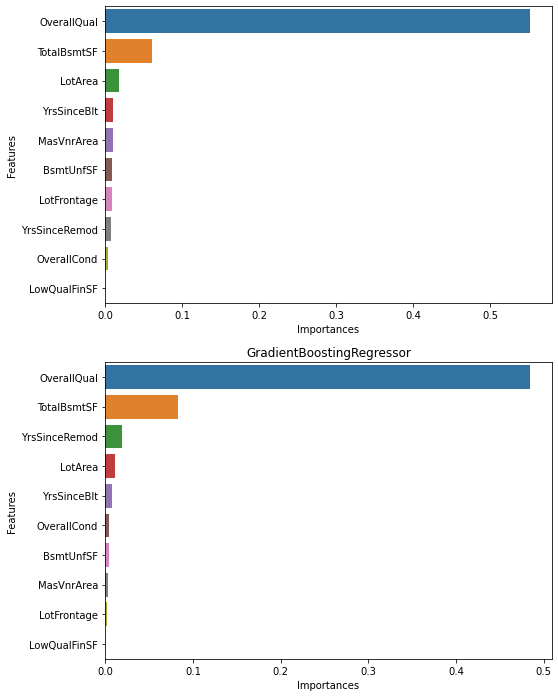

In [59]:
standards = [randomForest, gradientBoost]
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

for ax, standard in zip(axs.flat, standards):
    importance_df = pd.DataFrame({'Features': list(x_train.columns), 
                                  'Importances': list(standard.feature_importances_)}).head(10)
    importance_df.sort_values(by='Importances', ascending=False, inplace=True)
    
    # Plot Everything
    plt.title(str(standard).split('(')[0])
    sns.barplot(x=importance_df['Importances'], y=importance_df['Features'], ax=ax)

In order to achieve the same visualization with GridSearchCV, we will need to apply a different loop here.

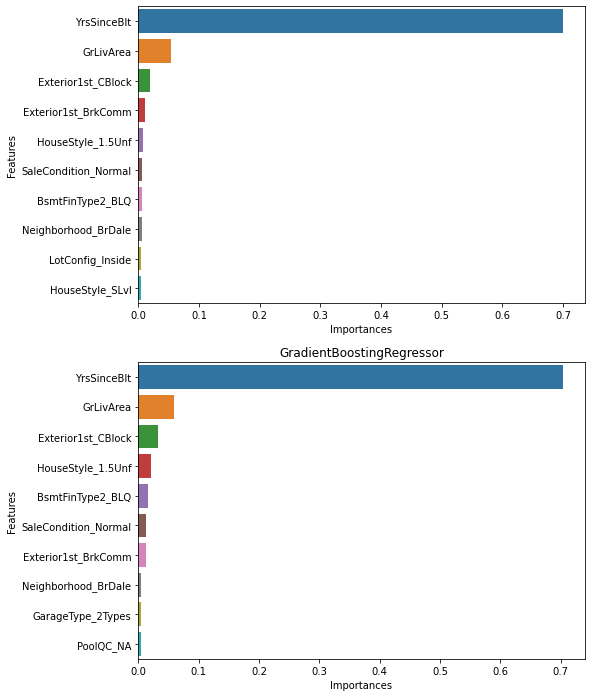

In [60]:
# Group gridsearches & prep plots
grids = [gs_randomForest, gs_gradientBoost]

fig, axs = plt.subplots(2, 1, figsize = (8, 12))

# Find & Plot Feature Importances
for ax, grid in zip(axs.flat, grids):
    bestmodel = grid.best_estimator_.steps[0][1]
    n_pcs = bestmodel.components_.shape[0]
    
    # Apply Pipelined PCA results to get feature names
    most_important = [np.abs(bestmodel.components_[i]).argmax() for i in range(n_pcs)]
    most_important_names = [x_train.columns[most_important[i]] for i in range(n_pcs)]
    
    # Zip & Sort Names and Importances
    zipped_feats = zip(most_important_names, 
                       grid.best_estimator_.steps[1][1].feature_importances_)
    zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
    
    # Get collect best features & importances into importances_df
    bestfeatures, bestimportances = zip(*zipped_feats)
    importance_df = pd.DataFrame({'Features': bestfeatures, 'Importances': bestimportances}).head(10)
    
    # Plot the things
    plt.title(str(grid.estimator.steps[1][1]).split('(')[0])
    sns.barplot(x = importance_df['Importances'], y=importance_df['Features'], ax=ax)

## Cooked Feature Importance
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In [ ]:
standards = [randomForest, gradientBoost]
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

for ax, standard in zip(axs.flat, standards):
    importance_df = pd.DataFrame({'Features': list(x_train.columns), 
                                  'Importances': list(standard.feature_importances_)}).head(10)
    importance_df.sort_values(by='Importances', ascending=False, inplace=True)
    
    # Plot Everything
    plt.title(str(standard).split('(')[0])
    sns.barplot(x=importance_df['Importances'], y=importance_df['Features'], ax=ax)

## Opting for Permutation Importance
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)


In addition to avoiding inherent biases of built-in feature importance calculation, SKLearn's **permutation_importance** enables us an easy, syntax-agnostic approach to its application across multiple model types. This should allow us to easily view and contrast the relative importance of features between tuned and non-tuned models.

/home/theodore/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


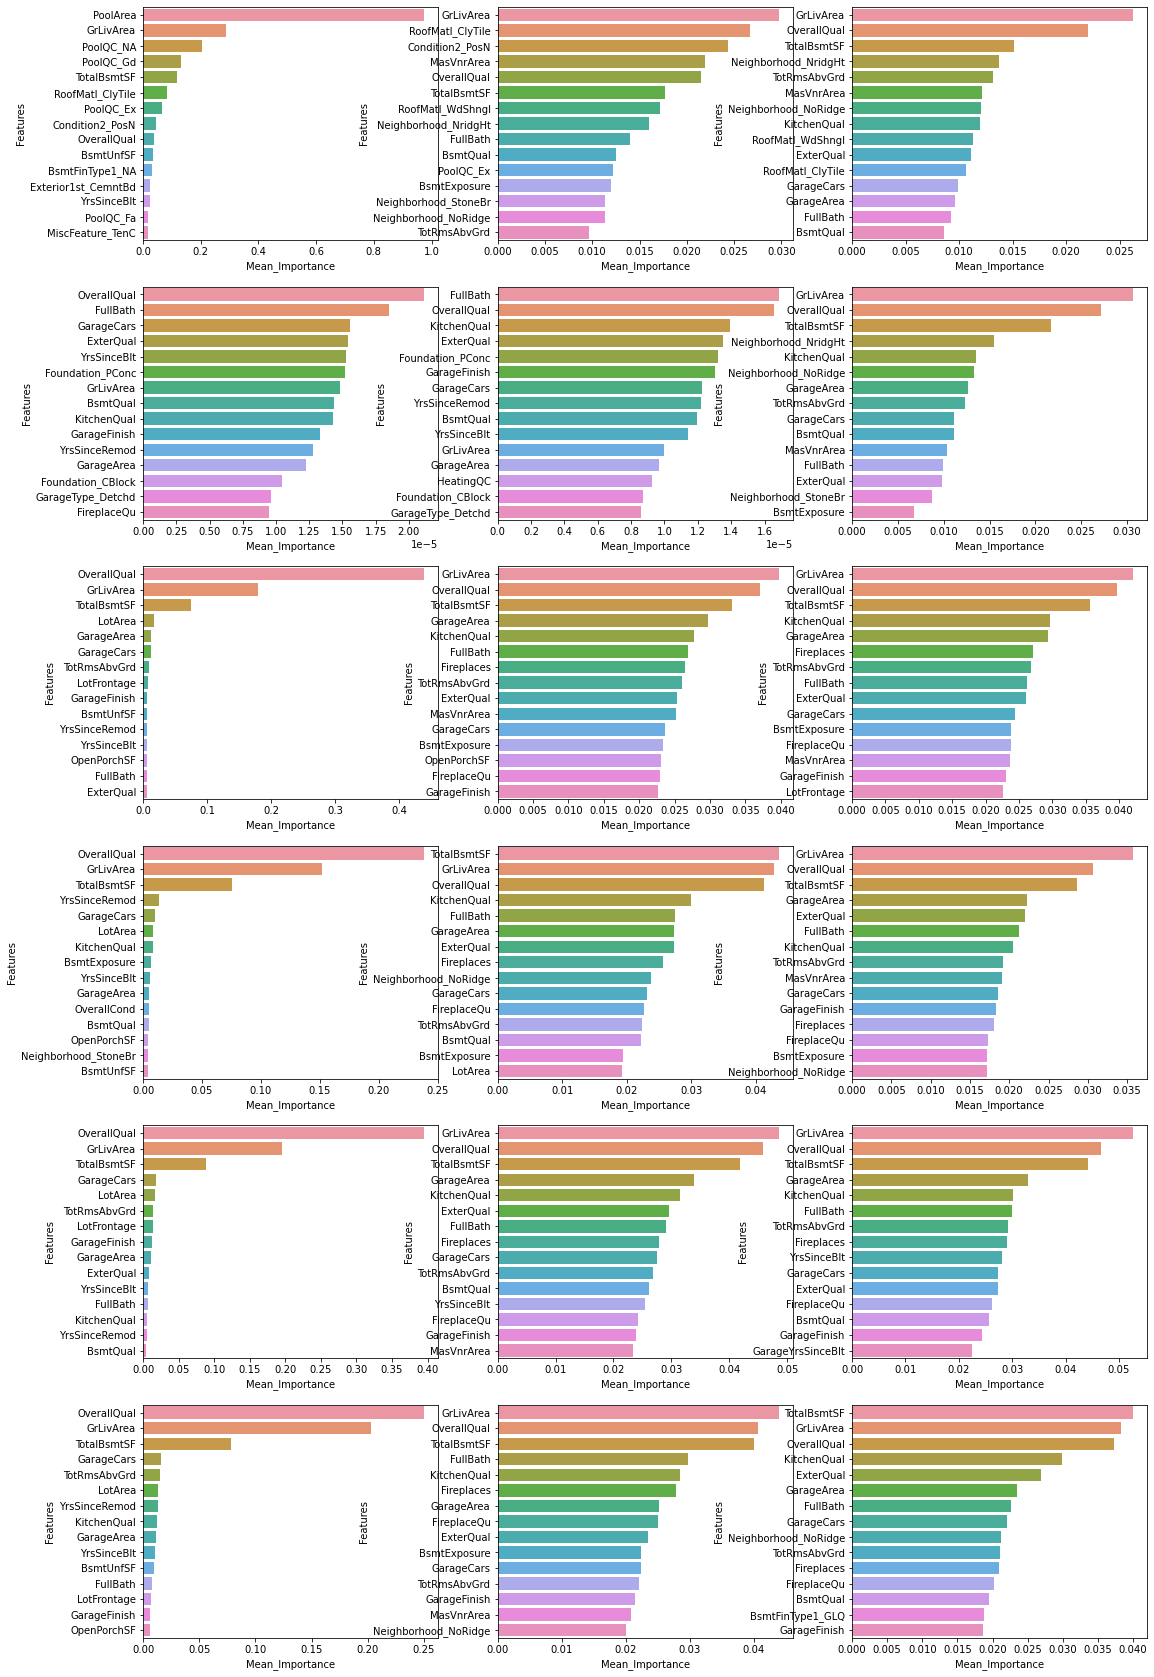

In [24]:
########################################
### Un-Cooked Permutation Importance ###
########################################

from sklearn.inspection import permutation_importance

# Collect all predictive models in use
all_models = [ridge, ridgep, gs_ridge, 
             svr, svrp, gs_svr,
             randomForest, rforestp, gs_randomForest,
             gradientBoost, gboostp, gs_gradientBoost,
             xgForest, xgrfp, gs_xgForest,
             xgBooster, xgbp, gs_xgBooster]
fig, axs = plt.subplots(6, 3, figsize=(18, 30))

# Prepare Plot Names
model_names = ['Ridge Regressor', 'PCA Ridge Regressor', 'GS Ridge Regressor',
              'SV Regressor', 'PCA SV Regressor', 'GS SV Regressor',
              'Random Forest', 'PCA Random Forest', 'GS Random Forest',
              'Gradient Boost', 'PCA Gradient Boost', 'GS Gradient Boost',
              'XGRF Regressor', 'PCA XGRF Regressor', 'GS XGRF Regressor',
              'XGBooster', 'PCA XGBooster', 'GS XGBooster']
m_idx = 0

# Get Permutation Importance & Plot
for ax, mod in zip(axs.flat, all_models):
    perms = permutation_importance(mod, x_train, y_train['SalePrice'],
                                  n_jobs=-2, random_state=430)
    
    # Generate Permutation DF
    perm_imp = pd.DataFrame({'Mean_Importance': list(perms['importances_mean']),
                            'Features': x_train.columns.to_list()})
    perm_imp = perm_imp.sort_values(by='Mean_Importance', ascending=False).head(15)
    
    # Plot
    sns.barplot(x=perm_imp['Mean_Importance'], y=perm_imp['Features'], ax=ax)
    m_idx += 1

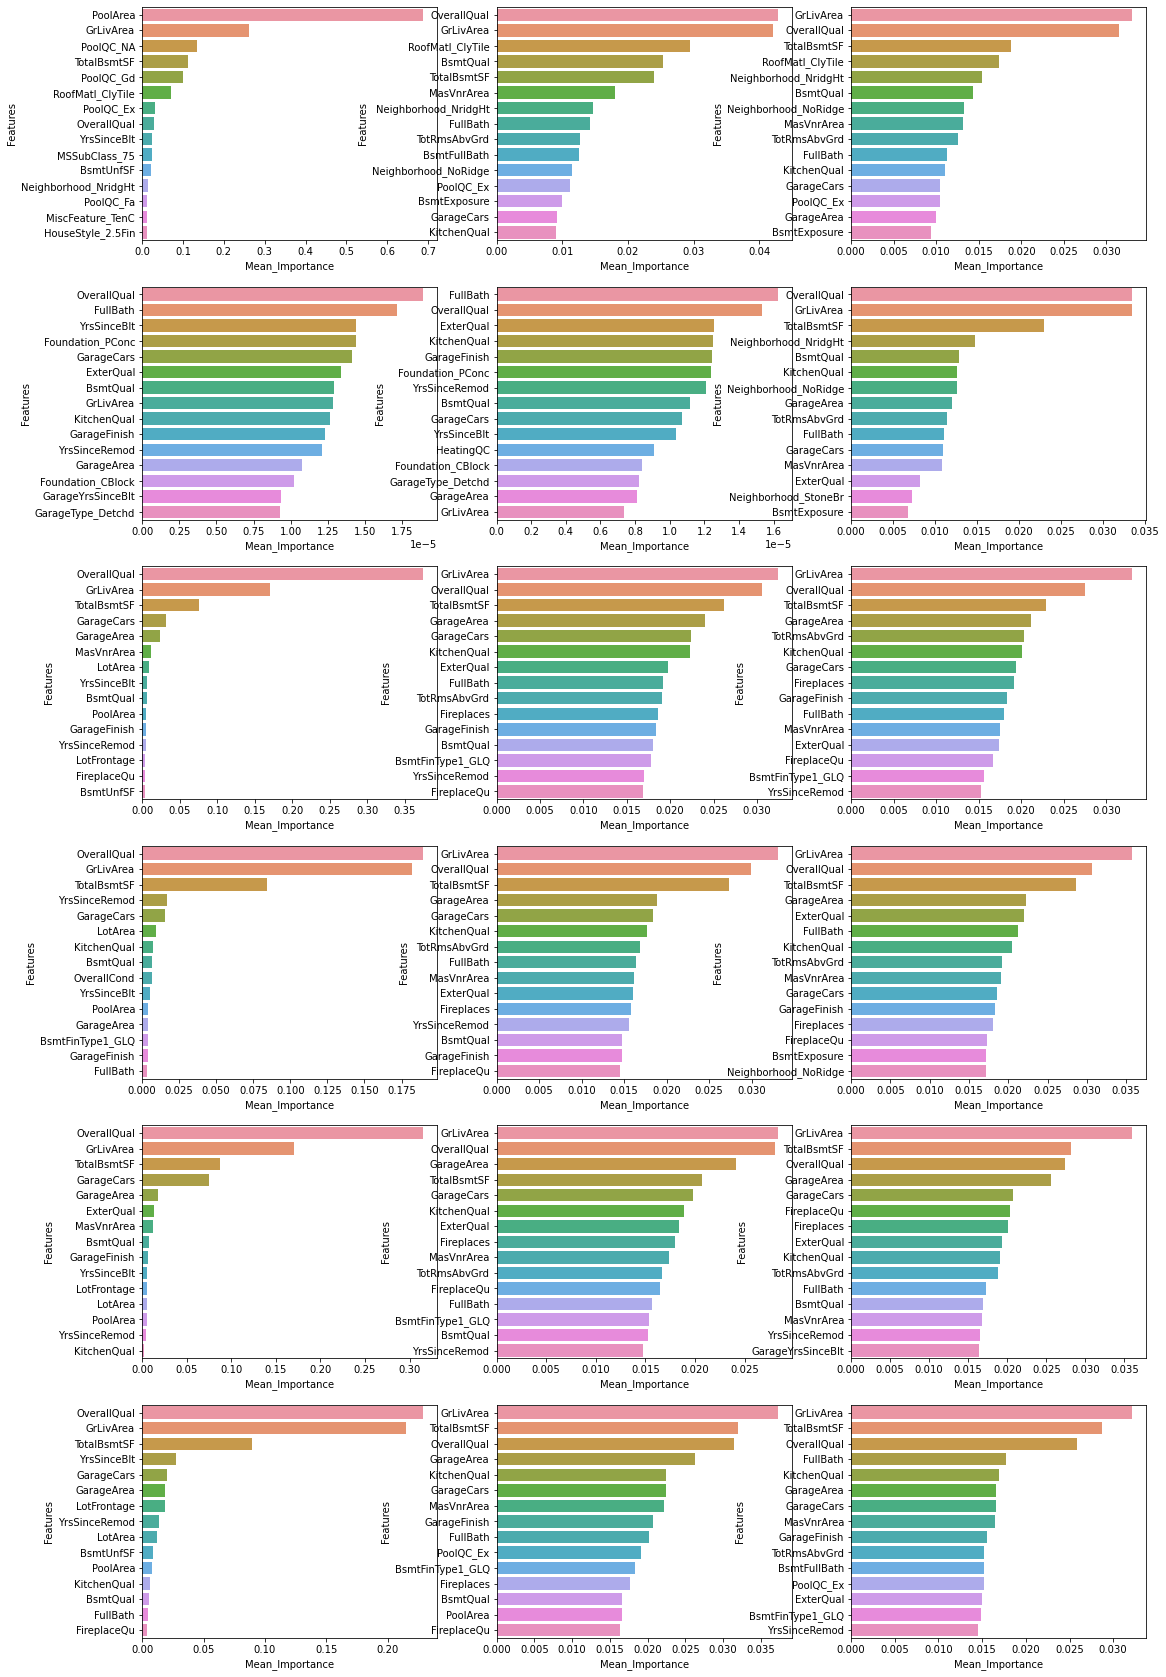

In [25]:
###########################################
### Fully Cooked Permutation Importance ###
###########################################

# Collect all predictive models in use
all_models = [ridge2, ridgep2, cooked_ridge, 
             svr2, svrp2, cooked_svr,
             randomForest2, rforestp2, cooked_randomForest,
             gradientBoost2, gboostp2, gs_gradientBoost,
             xgForest2, xgrfp2, cooked_xgForest,
             xgBooster2, xgbp2, cooked_xgBoost]
fig, axs = plt.subplots(6, 3, figsize=(18, 30))

# Prepare Plot Names
model_names = ['Ridge Regressor', 'PCA Ridge Regressor', 'GS Ridge Regressor',
              'SV Regressor', 'PCA SV Regressor', 'GS SV Regressor',
              'Random Forest', 'PCA Random Forest', 'GS Random Forest',
              'Gradient Boost', 'PCA Gradient Boost', 'GS Gradient Boost',
              'XGRF Regressor', 'PCA XGRF Regressor', 'GS XGRF Regressor',
              'XGBooster', 'PCA XGBooster', 'GS XGBooster']
m_idx = 0

# Get Permutation Importance & Plot
for ax, mod in zip(axs.flat, all_models):
    perms = permutation_importance(mod, x_train, y_train['SalePrice'],
                                  n_jobs=-2, random_state=430)
    
    # Generate Permutation DF
    perm_imp = pd.DataFrame({'Mean_Importance': list(perms['importances_mean']),
                            'Features': x_train.columns.to_list()})
    perm_imp = perm_imp.sort_values(by='Mean_Importance', ascending=False).head(15)
    
    # Plot
    sns.barplot(x=perm_imp['Mean_Importance'], y=perm_imp['Features'], ax=ax)
    m_idx += 1

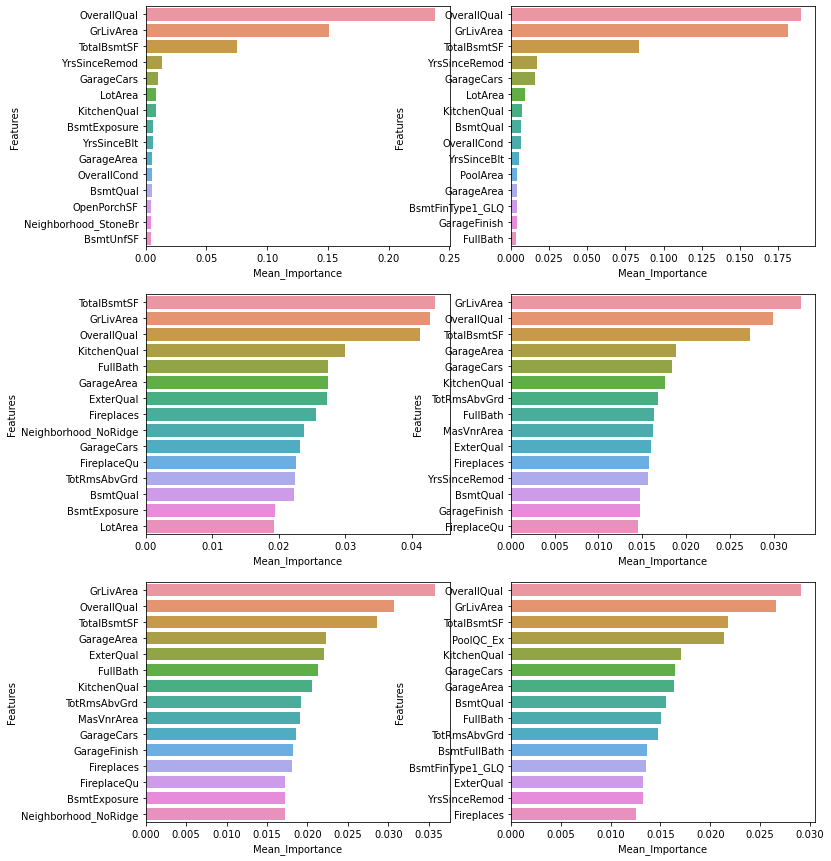

In [28]:

gboosts = [gradientBoost, gradientBoost2,
          gboostp, gboostp2,
          gs_gradientBoost, cooked_gradientBoost]

gb_names = ['Uncooked GradientBoost', 'Cooked GradientBoost',
           'Uncooked PCA GB', 'Cooked PCA GB',
           'Uncooked PCA/GS GB', 'Cooked PCA/GS GB']

fig, axs = plt.subplots(3, 2, figsize=(12, 15))
m_idx = 0

for ax, mod in zip(axs.flat, gboosts):
    perms = permutation_importance(mod, x_train, y_train['SalePrice'],
                                  n_jobs=-2, random_state=430)
    
    # Generate Perm DF
    perm_imp = pd.DataFrame({'Mean_Importance': list(perms['importances_mean']),
                            'Features': x_train.columns.to_list()})
    perm_imp = perm_imp.sort_values(by='Mean_Importance', ascending=False).head(15)
    
    # Plot
    sns.barplot(x=perm_imp['Mean_Importance'], y=perm_imp['Features'], ax=ax)
#     plt.title(gb_names[m_idx])
    m_idx += 1

Text(0.5, 1.0, 'GradientBoostingRegressor Permutation Importance')

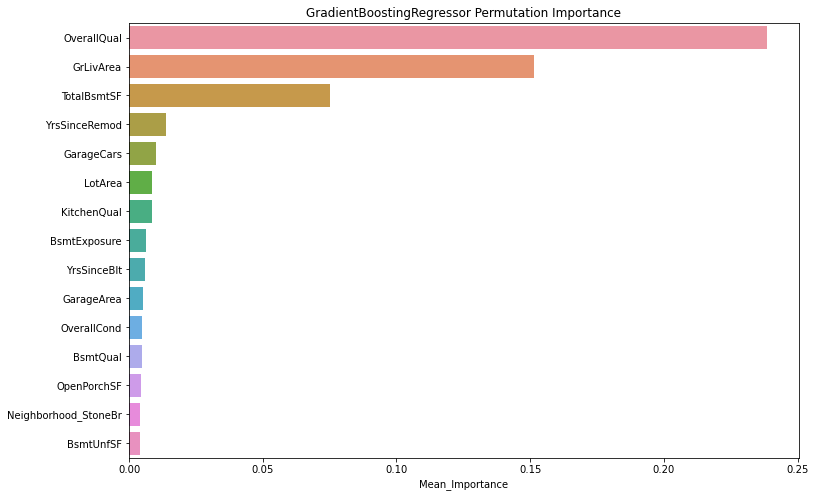

In [22]:
#######################################
### Focus GradientBoostingRegressor ###
#######################################

fig, axs = plt.subplots(figsize=(12, 8))

perms = permutation_importance(gradientBoost, x_train, y_train['SalePrice'],
                              n_jobs=-2, random_state=430)
perm_imp = pd.DataFrame({'Mean_Importance': list(perms['importances_mean']),
                        'Features': x_train.columns.to_list()})
perm_imp = perm_imp.sort_values(by='Mean_Importance', ascending=False).head(15)

sns.barplot(x=perm_imp['Mean_Importance'], y=perm_imp['Features'])
plt.ylabel('')
plt.title('GradientBoostingRegressor Permutation Importance')

# Make Predictions
[[Back to Top]](#Iowa-Housing-Pricing:-Modeling-&-Analysis)



In [146]:
testset = pd.read_csv('test.csv')

In [147]:
testset.shape

(1459, 80)

In [148]:
testset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [149]:
testset = data_prep(testset, imputer, ordinal, ohe, scale)
rf_predictions = best_RandomForest.predict(testset)
rf_predictions = pd.DataFrame(rf_predictions).rename(columns = {0:'SalePrice'})

/home/theodore/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
[Parallel(n_jobs=11)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:    0.0s
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [150]:
rf_predictions

,SalePrice
0,122175.074431
1,146125.838607
2,161061.716860
3,167970.228044
4,196198.157914
...,...
1454,79880.487112
1455,87224.141011
1456,147346.763134
1457,108746.269380


In [151]:
# save info
pickle.dump(best_RandomForest, open('./bestRFmodel', 'wb'))
rf_predictions.to_csv('IowaHousingPredictions')